In [ ]:
#!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz


In [ ]:
#!tar xzvf food-101.tar.gz


In [ ]:
#pip install livelossplot


In [1]:
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

In [2]:
def split_dataset(root_food_path):
    data_paths = {
        'train': root_food_path/'meta/train.json',
        'test': root_food_path/'meta/test.json'
    }
    for data_type, meta_path in data_paths.items():
        os.makedirs(root_food_path/data_type, exist_ok=True)
        food_images = json.load(open(meta_path, 'r'))
        for food_name, image_paths in food_images.items():
            os.makedirs(root_food_path/data_type/food_name, exist_ok=True)
            for image_path in image_paths:
                image_path = image_path + '.jpg'
                shutil.move(root_food_path/'images'/image_path, root_food_path/data_type/image_path)

download_dir = Path('./')

#split_dataset(download_dir/'food-101')

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

In [4]:
train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    #brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    #width_shift_range=0.5,       # shift the width of the image 50%
    #height_shift_range=0.5,
    #rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)
class_subset = sorted(os.listdir(download_dir/'food-101/images'))[:10]
BATCH_SIZE = 32

training = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validation = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 6380 images belonging to 10 classes.
Found 1120 images belonging to 10 classes.


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

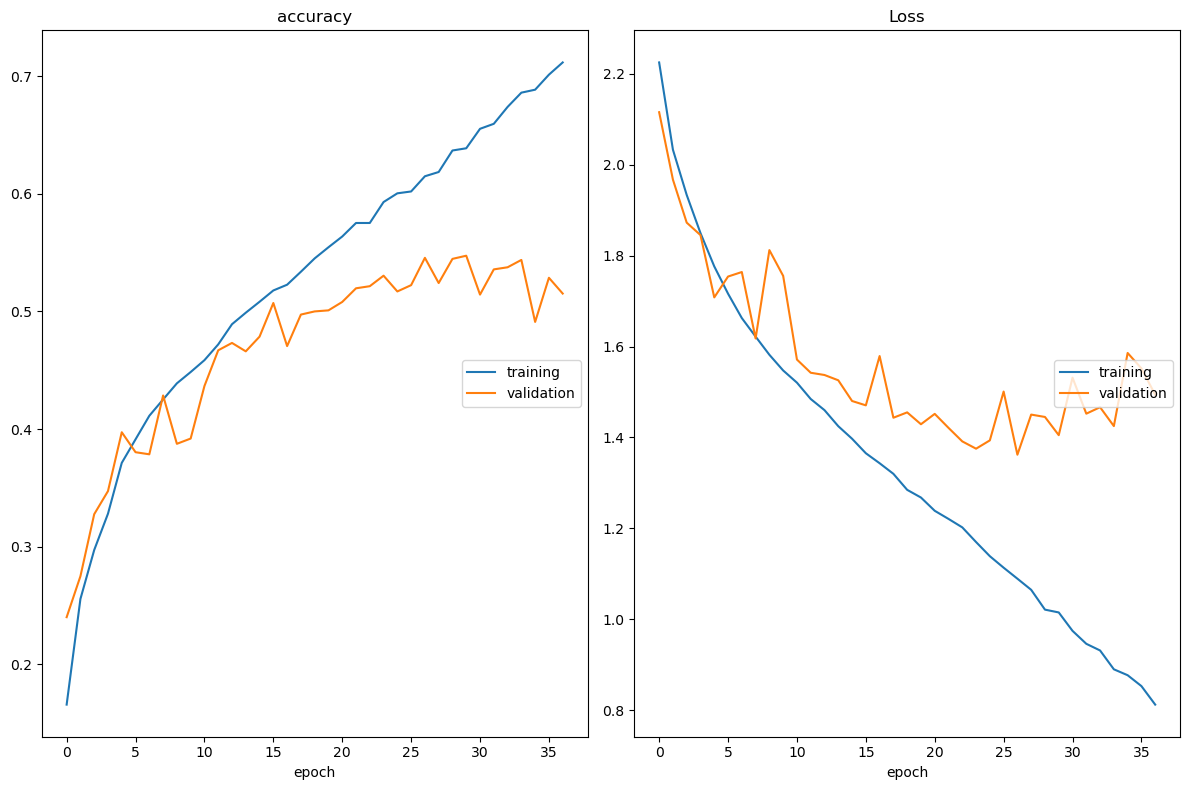

accuracy
	training         	 (min:    0.166, max:    0.712, cur:    0.712)
	validation       	 (min:    0.240, max:    0.547, cur:    0.515)
Loss
	training         	 (min:    0.812, max:    2.225, cur:    0.812)
	validation       	 (min:    1.362, max:    2.116, cur:    1.494)
199/199 [==============================] - 34s 168ms/step - loss: 0.8121 - accuracy: 0.7116 - val_loss: 1.4940 - val_accuracy: 0.5152
CPU times: total: 24min 32s
Wall time: 21min 13s


In [6]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

steps_per_epoch = training.samples // BATCH_SIZE
val_steps = validation.samples // BATCH_SIZE

n_epochs = 60

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='./food_model_flips.weights.hdf5',
                               verbose=1,
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(training,
                    epochs=n_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    #verbose=False)
)

In [7]:
from keras.models import load_model

scratch_model = load_model('./food_model_flips.weights.hdf5')

scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [8]:
test_generator = ImageDataGenerator(rescale=1/255.,
                                    brightness_range=[0.5, 1.5]
                                    )

testgen = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                             shuffle=False,
                                             seed=42)

Found 2500 images belonging to 10 classes.


In [9]:
import numpy as np
model.load_weights('./food_model_flips.weights.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis=-1)

class_indices = training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

2500/2500 [==============================] - 19s 7ms/step


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)

    results.sort_values(by='F-Score', ascending=False, inplace=True)
    global_acc = accuracy_score(y_true, y_preds)

    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))


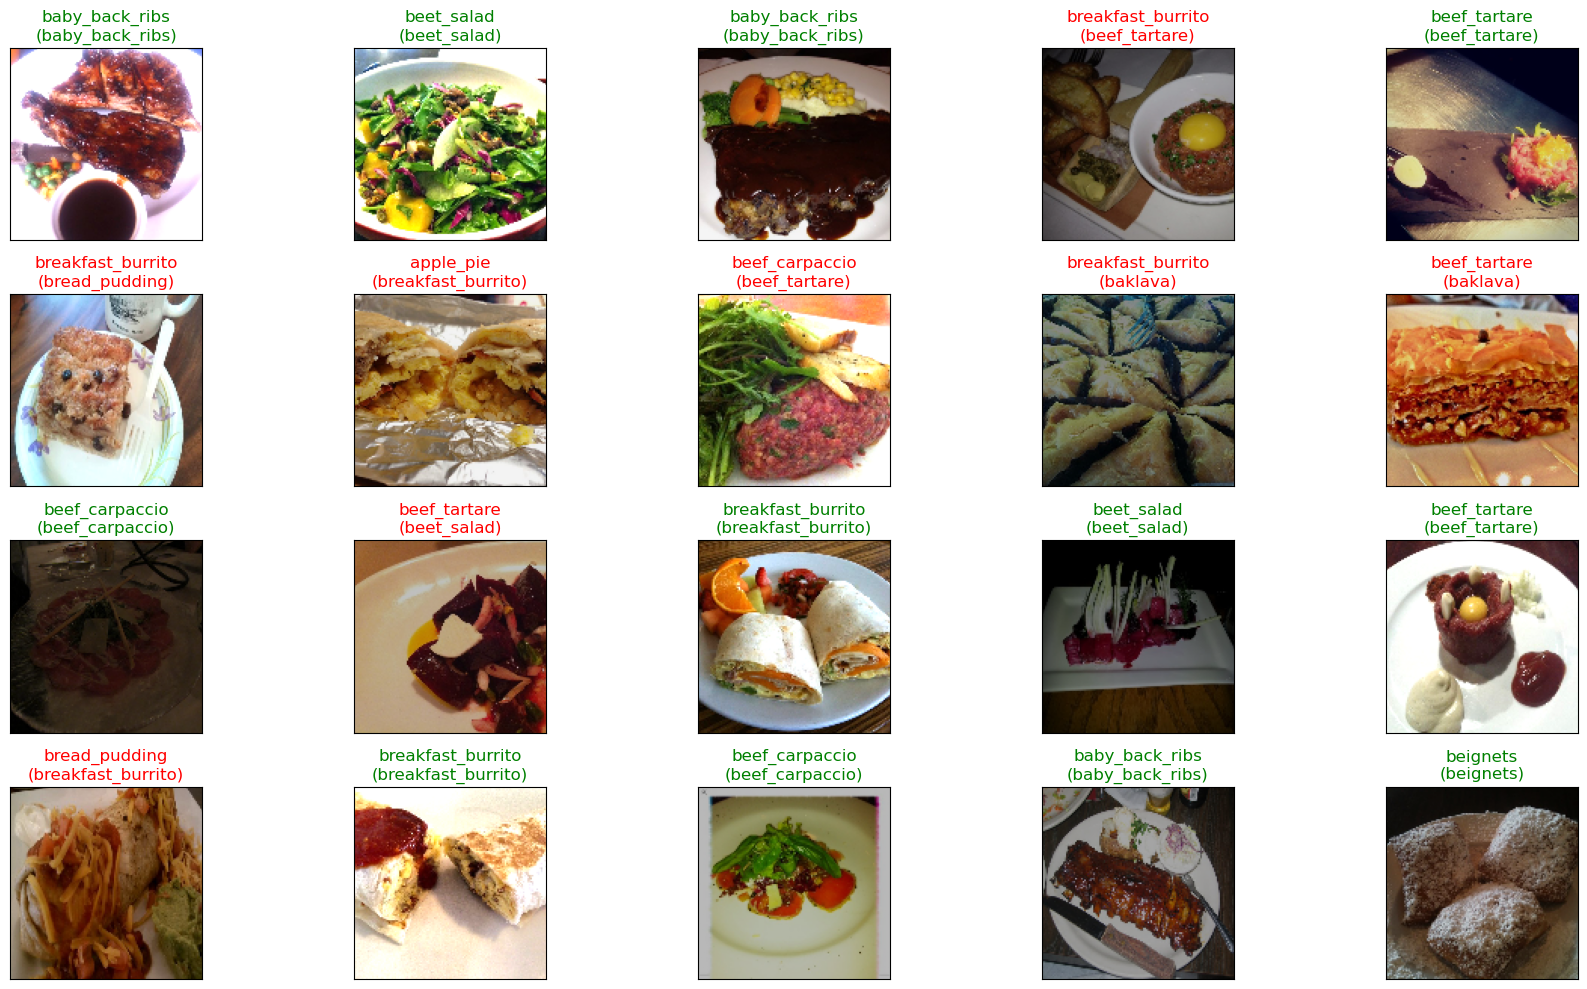

In [11]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)


In [12]:
display_results(true_classes, predicted_classes, class_indices.values())


Overall Categorical Accuracy: 56.24%


,Precision,Recall,F-Score,Support
beef_carpaccio,0.705882,0.768,0.735632,250.0
bibimbap,0.684015,0.736,0.709056,250.0
baby_back_ribs,0.740909,0.652,0.693617,250.0
beignets,0.660305,0.692,0.675781,250.0
beet_salad,0.726415,0.616,0.666667,250.0
beef_tartare,0.512903,0.636,0.567857,250.0
baklava,0.585987,0.368,0.452088,250.0
breakfast_burrito,0.355191,0.520,0.422078,250.0
bread_pudding,0.363636,0.416,0.388060,250.0
apple_pie,0.376712,0.220,0.277778,250.0


Overall Categorical Accuracy: 56.24%


<Axes: >

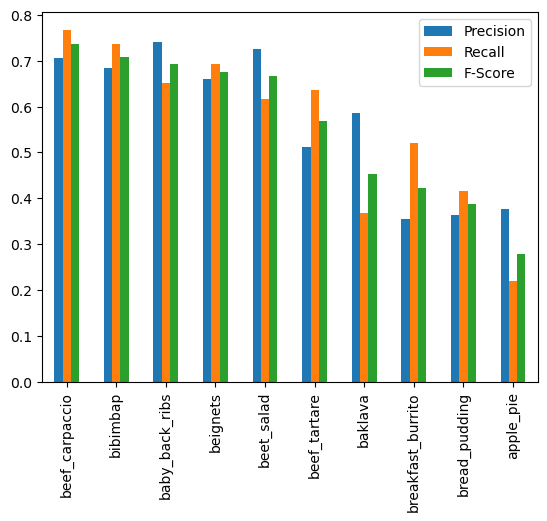

In [13]:
df = display_results(true_classes, predicted_classes, class_indices.values())
df = df.drop(['Support'], axis=1)
df.plot(kind='bar')

**Transfer leaning**

In [ ]:
from keras.models import load_model

scratch_model = load_model('/content/drive/MyDrive/food_model.weights.hdf5')

scratch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                        

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [ ]:
training = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validation = train_generator.flow_from_directory(download_dir/'food-101/train',
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testing = test_generator.flow_from_directory(download_dir/'food-101/test',
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 6380 images belonging to 10 classes.
Found 1120 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = training.samples // BATCH_SIZE
n_val_steps = validation.samples // BATCH_SIZE
n_epochs = 35

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/food_model.weights.feature.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

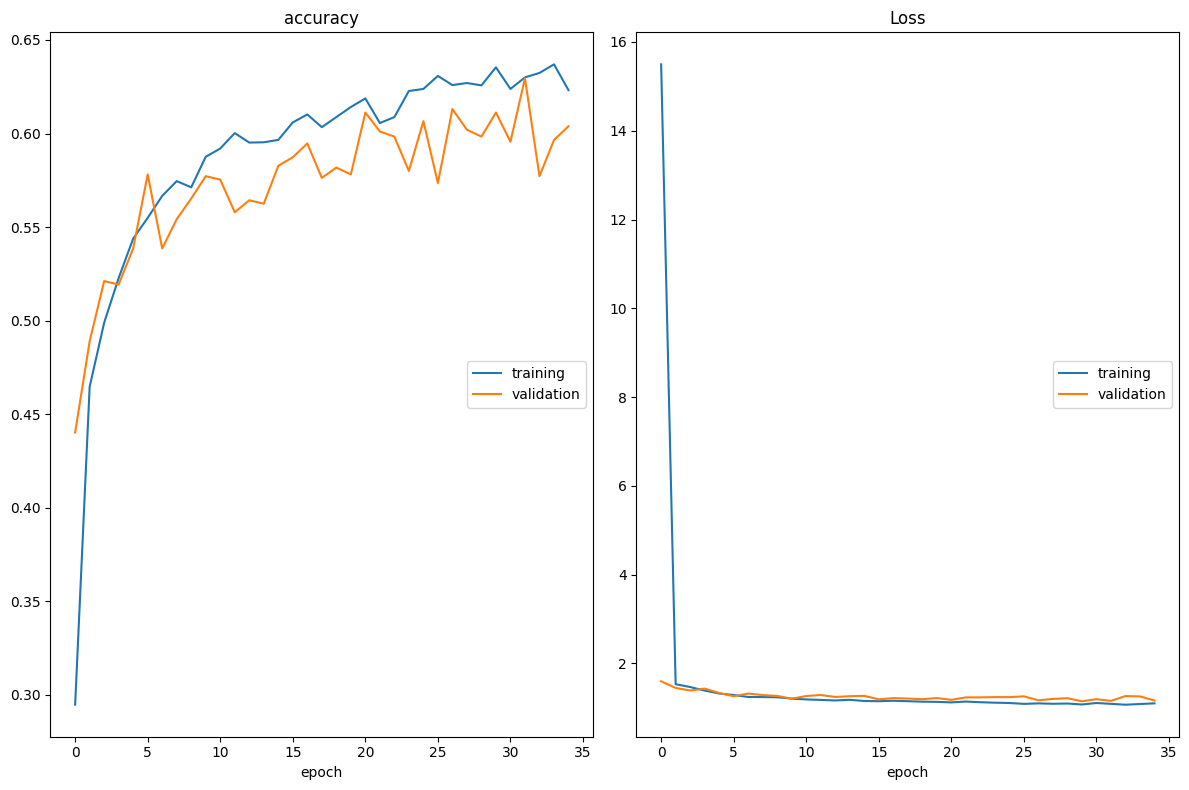

accuracy
	training         	 (min:    0.295, max:    0.637, cur:    0.623)
	validation       	 (min:    0.440, max:    0.630, cur:    0.604)
Loss
	training         	 (min:    1.066, max:   15.496, cur:    1.097)
	validation       	 (min:    1.143, max:    1.594, cur:    1.161)
99/99 [==============================] - 157s 2s/step - loss: 1.0973 - accuracy: 0.6232 - val_loss: 1.1606 - val_accuracy: 0.6039
CPU times: user 1h 22min 38s, sys: 4min 19s, total: 1h 26min 57s
Wall time: 1h 44min 2s


In [ ]:
%%time

vgg_history = vgg_model.fit(training,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validation,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Generate predictions
vgg_model.load_weights('/content/drive/MyDrive/food_model.weights.feature.hdf5') # initialize the best trained weights

true_classes = testing.classes
class_indices = training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_pred_classes = np.argmax(vgg_model.predict(testing), axis=-1)

2500/2500 [==============================] - 30s 12ms/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 74.04%
